# 1 Define the Problem

    What is the input data?
    What type of problem? Multiclass singlelabel classification


# 2 Choosing a measure of success

    Accuracy?
    Precision and recall?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [30]:
import tensorflow as tf
import keras
from keras import models, layers, regularizers, optimizers

from keras.datasets import cifar10

# empty array to store future model information
model_summary = []

# load data from library
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'{X_train.shape[0]} train samples')
print(f'{X_test.shape[0]} test samples')

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
# examine data in first sample with label
print(f'first sample:\n{X_train[0][0][:5]}\n...\n')
print(f'first label: {y_train[0]}')

first sample:
[[59 62 63]
 [43 46 45]
 [50 48 43]
 [68 54 42]
 [98 73 52]]
...

first label: [6]


In [4]:
# mapping of label to names
target_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"}

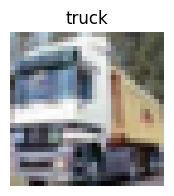

In [5]:
# plot single image sample from data set
def plot_sample(sample=X_train[0], label=6):
    data = sample

    # set plot parameters
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.title(target_names[label])

    # Use imshow to plot pixels
    plt.imshow(data)

    # Display the plot
    plt.show()


plot_sample(X_train[1], y_train[1][0])

12 sample plot


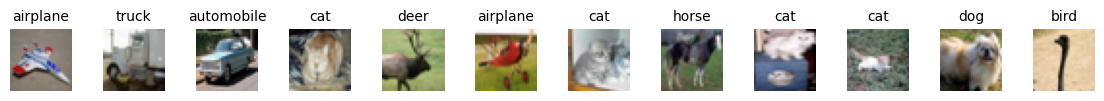

In [6]:
# plot multiple images from cifar10 dataset as subplots
def plot_multi_sample(samples=X_train[0:8], labels=[6, 9, 9, 4, 1, 1, 2, 7], pred_labels=None):
    length = len(samples)

    # create horizontal figure with subplots
    fig, axes = plt.subplots(1, length, figsize=(14, 8))
    axes = axes.flatten()

    # create subplot for each image data
    for i in range(length):
        data = samples[i]
        label = labels[i]

        # plot parameters
        plt.subplot(1, length, i+1)
        plt.axis('off')

        if pred_labels is not None:
            plt.title(f'True: {target_names[labels[i]]}\nPred: {target_names[pred_labels[i]]}',
                      fontsize=10)
        else:
            plt.title(target_names[labels[i]],
                      fontsize=10)
        plt.subplots_adjust(wspace=0.5)
        plt.imshow(samples[i])

    # display sample count and show plot
    print(f'{length} sample plot')
    plt.show()


plot_multi_sample(X_train[30:42], [y[0] for y in y_train[30:42]])

# 3 Deciding on an Evaluation Protocol

    Hold-out? Our dataset is sufficiently big and well balanced
    K-fold?


In [7]:
from sklearn.model_selection import train_test_split

# split into validation data and partial training data
# stratify=y_train to ensure even porportion of split labels
x_partial, x_val, y_partial, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2, stratify=y_train)

print(x_partial.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')


40000 train samples
10000 validation samples
10000 test samples


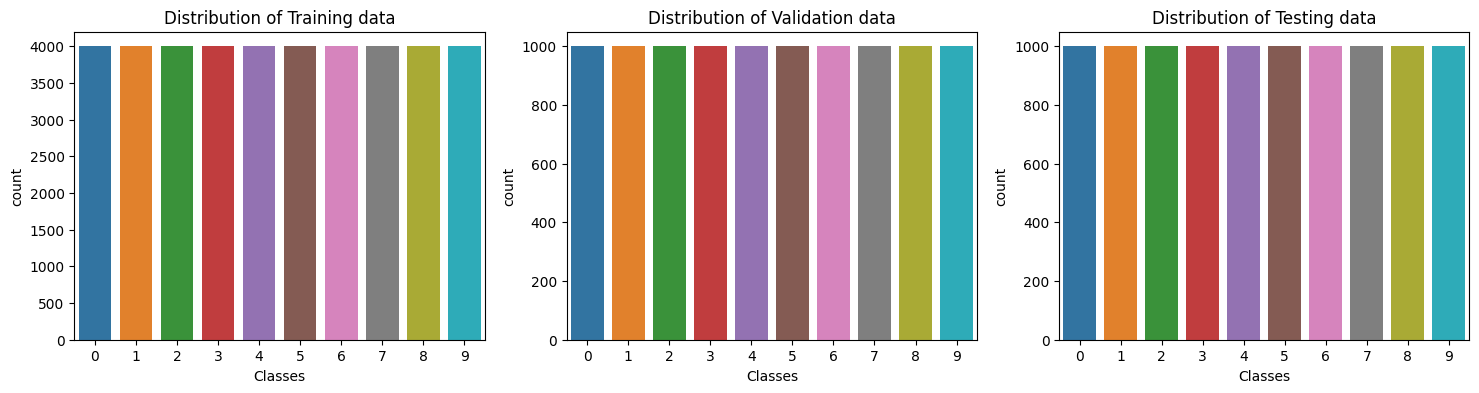

In [8]:
# show distribution of samples by countplot

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
# plot for training set
sns.countplot(x=y_partial.ravel(), ax=axes[0])
axes[0].set_title('Distribution of Training data')
axes[0].set_xlabel('Classes')

# plot for validation set
sns.countplot(x=y_val.ravel(), ax=axes[1])
axes[1].set_title('Distribution of Validation data')
axes[1].set_xlabel('Classes')

# plot for testing set
sns.countplot(x=y_test.ravel(), ax=axes[2])
axes[2].set_title('Distribution of Testing data')
axes[2].set_xlabel('Classes')
plt.show()


# 4 Preparing your data

    Manipulate into tensors
    Normalize values [0, 1]
    Data visualization is not necessary


In [9]:
# from tensorflow.keras.utils import to_categorical

"""
preprocess data, normalize range to [0,1]
"""
def prep_normalize(data):
    data = data.astype('float32') / 255
    return data


"""
one-hot encode integer label data to categorical
"""
def prep_encoder(data, classes=10):
    data = tf.keras.utils.to_categorical(
        data, num_classes=classes, dtype='float32'
    )
    return data

In [10]:
# normalize samples
x_partial = prep_normalize(x_partial)
x_val = prep_normalize(x_val)
x_test = prep_normalize(X_test)

# one-hot encode labels
y_partial = prep_encoder(y_partial)
y_val = prep_encoder(y_val)

y_test = y_test.ravel()

print(x_partial)
print(y_partial)

[[[[0.44705883 0.72156864 0.8509804 ]
   [0.4392157  0.70980394 0.8392157 ]
   [0.44313726 0.70980394 0.8392157 ]
   ...
   [0.4392157  0.7019608  0.84313726]
   [0.43529412 0.7019608  0.84313726]
   [0.43529412 0.7058824  0.84313726]]

  [[0.44705883 0.72156864 0.84705883]
   [0.4392157  0.70980394 0.8352941 ]
   [0.44313726 0.70980394 0.8352941 ]
   ...
   [0.43137255 0.69803923 0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43529412 0.70980394 0.8392157 ]]

  [[0.45490196 0.73333335 0.84705883]
   [0.44313726 0.7176471  0.827451  ]
   [0.44313726 0.7137255  0.827451  ]
   ...
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.70980394 0.83137256]]

  ...

  [[0.8784314  0.78039217 0.6039216 ]
   [0.83137256 0.7372549  0.5647059 ]
   [0.8235294  0.7294118  0.5568628 ]
   ...
   [0.8666667  0.74509805 0.5372549 ]
   [0.8392157  0.7176471  0.5058824 ]
   [0.84705883 0.73333335 0.52156866]]

  [[0.8392157  0.7411765  0.5686275 ]
   [0.8

In [11]:
# helper functions

"""
function to plot model history
"""
def plot_history(history, name='Model'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # plot training & valid loss
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title(f'{name} Loss History')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Training', 'Validation'])
    axes[0].grid(linestyle='dotted')
    # axes[0].legend(['Training', 'Validation'], loc='upper left')

    # plot training & valid accuracy
    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title(f'{name} Accuracy History')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Training', 'Validation'])
    axes[1].grid(linestyle='dotted')
    plt.show()


# loss and accuracy with testing set
def evaluate_model(model):
    loss, acc = model.evaluate(x_test, prep_encoder(y_test), verbose=1)
    print(f'Test loss: {loss}')
    print(f'Test accu: {acc}')
    return loss, acc


# optimal epoch
def optimal_epoch(history):
    min_loss = np.argmin(history.history['val_loss'])
    max_accu = np.argmax(history.history["val_accuracy"])
    print(f'Min loss at epoch: {min_loss}')
    print(f'Max accu at epoch: {max_accu}')
    return min_loss, max_accu


In [12]:
# more helper functions

"""
moving average
stackoverflow.com/questions/20618804/how-to-smooth-a-curve-for-a-dataset#answer-26337730
"""
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


"""
plot multiple history graphs for comparing rate differences
"""
def plot_history_comparison(histories, legend_names, title, lim=None, dotted=None):
    SMOOTH_N = 10  # number of last datapoints to average

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # plot training & valid loss for multiple models
    for i, history in enumerate(histories):
        # truncate and smooth data before plotting
        data = smooth(history.history['val_loss'], SMOOTH_N)
        if lim:
            data = data[:lim]
        if dotted and i+1 in dotted:
            axes[0].plot(data, linestyle='dotted')
        else:
            axes[0].plot(data)
    axes[0].set_title(f'{title} Validation Loss Comparison')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(legend_names)
    axes[0].grid(linestyle='dotted')

    # plot training & valid accuracy
    for i, history in enumerate(histories):
        # truncade and smooth data before plotting
        data = smooth(history.history['val_accuracy'], SMOOTH_N)
        if lim:
            data = data[:lim]
        if dotted and i+1 in dotted:
            axes[1].plot(data, linestyle='dotted')
        else:
            axes[1].plot(data)
    axes[1].set_title(f'{title} Validation Accuracy Comparison')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(legend_names)
    axes[1].grid(linestyle='dotted')
    plt.show()

# 5 Developing a model that does better than a baseline

    Aim for statistical power
    State the common-sense baseline: 10%
    Last layer? softmax
    Loss Function? crossentropy
    Optimizer? RMSProp


- multiclass single label dataset, use crossentropy for loss
- this is classification, so we'll use accuracy as the metric
- for now use rmsprop as the optimizer

- image classification, for the sake of baseline comparisons, we'll start with a dense layer and compare with convolution layers later
- it will be as large as the input shape


In [19]:
"""
baseline two layer dense model width:32
"""
def dense_baseline_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
              input_shape=X_train[0].shape))
    model.add(layers.Flatten())  # flatten dimensions before output
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameters
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


model = dense_baseline_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32, 32, 32)        128       
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                327690    
                                                                 
Total params: 327,818
Trainable params: 327,818
Non-trainable params: 0
_________________________________________________________________


In [20]:
N_EPOCHS = 100
BATCH_SIZE = 32


history = model.fit(x_partial, y_partial,
                    validation_data=(x_val, y_val),
                    epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/100
1250/1250 [==============================] - 16s 12ms/step - loss: 1.7474 - accuracy: 0.4010 - val_loss: 1.5999 - val_accuracy: 0.4397
Epoch 2/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.5426 - accuracy: 0.4700 - val_loss: 1.5684 - val_accuracy: 0.4612
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4864 - accuracy: 0.4912 - val_loss: 1.5445 - val_accuracy: 0.4667
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4480 - accuracy: 0.5025 - val_loss: 1.5255 - val_accuracy: 0.4801
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4198 - accuracy: 0.5152 - val_loss: 1.5365 - val_accuracy: 0.4726
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.3954 - accuracy: 0.5268 - val_loss: 1.5369 - val_accuracy: 0.4735
Epoch 7/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.3782 - accuracy: 0.5328 - val_loss: 1

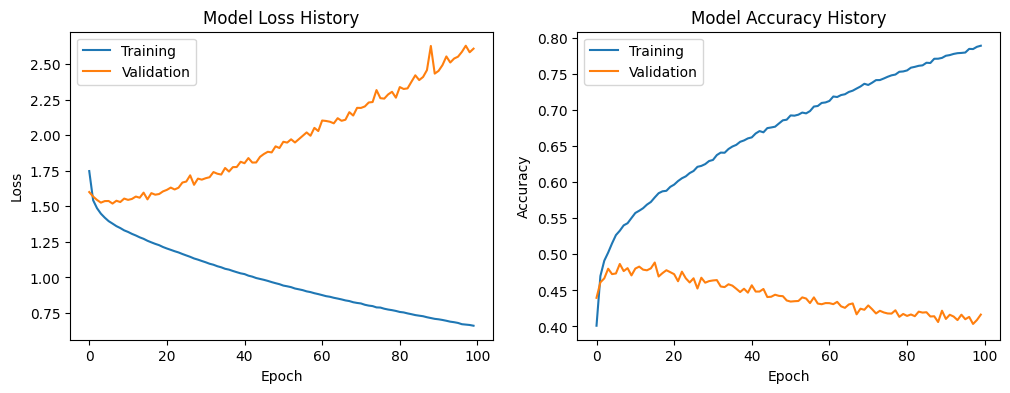

In [21]:
plot_history(history)


In [24]:
# loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model)

# optimal epoch
loss_epoch, accu_epoch = optimal_epoch(history)
lowest_loss = history.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model', N_EPOCHS, BATCH_SIZE, 0, 32, model.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 8ms/step - loss: 2.5588 - accuracy: 0.4122
Test loss: 2.5587668418884277
Test accu: 0.41220003366470337
Min loss at epoch: 6
Max accu at epoch: 15


(6, 15)

Number of correct predictions: 4122/10000
Prediction accuracy: 0.4122
10 sample plot


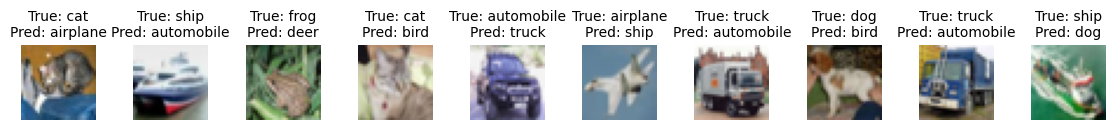

In [25]:
# use trained model to predict testing data, same as model.evaluate()
y_pred = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# get index count of false predictions
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of correct predictions: {test_samples-errors}/{test_samples}')
print(f'Prediction accuracy: {1-errors/test_samples}')

# plot incorrect preditions, true vs predicted labels
plot_multi_sample(X_test[errors_index][:10],
                  y_test[errors_index][:10].ravel(),
                  y_pred[errors_index][:10])

convolutional architecture


# 6 Scaling up - Developing a model that overfits

    From statistical power to sufficient power
    Increase model capacity, +layers, layersize
    Monitor overfitting and validation loss and other metrics
    Demonstrate graphically and in text overfitting


- a common convolutional architecture to increase depth is grouping 'blocks' of two conv2d and one maxpooling
- it removes the variance filter size, using only 3x3 stride 2
- depth of each sequential block doubles
- first introduced in vgg16


In [13]:
"""
two block model following vgg16
"""


def conv2d_model(blocks=1, optimizer='rmsprop', layer_size=1, padding='valid'):
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding=padding,
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
              activation='relu', padding=padding))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 2
    if blocks > 1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 3
    if blocks > 2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # head output
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2, blocks-1) * layer_size))
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameters
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [27]:
# model 'a' with one convolutional block
model_a = conv2d_model(blocks=1)
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                401472    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                      

In [28]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_a = model_a.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 17ms/step - loss: 1.6594 - accuracy: 0.4100 - val_loss: 1.4893 - val_accuracy: 0.4801
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 1.2892 - accuracy: 0.5491 - val_loss: 1.2073 - val_accuracy: 0.5776
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 1.1245 - accuracy: 0.6059 - val_loss: 1.1004 - val_accuracy: 0.6176
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 1.0133 - accuracy: 0.6480 - val_loss: 1.1666 - val_accuracy: 0.5922
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 0.9281 - accuracy: 0.6762 - val_loss: 1.1163 - val_accuracy: 0.6174
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.8568 - accuracy: 0.7018 - val_loss: 1.0422 - val_accuracy: 0.6432
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.7874 - accuracy: 0.7267 - val_loss: 1.1130 - val_accuracy:

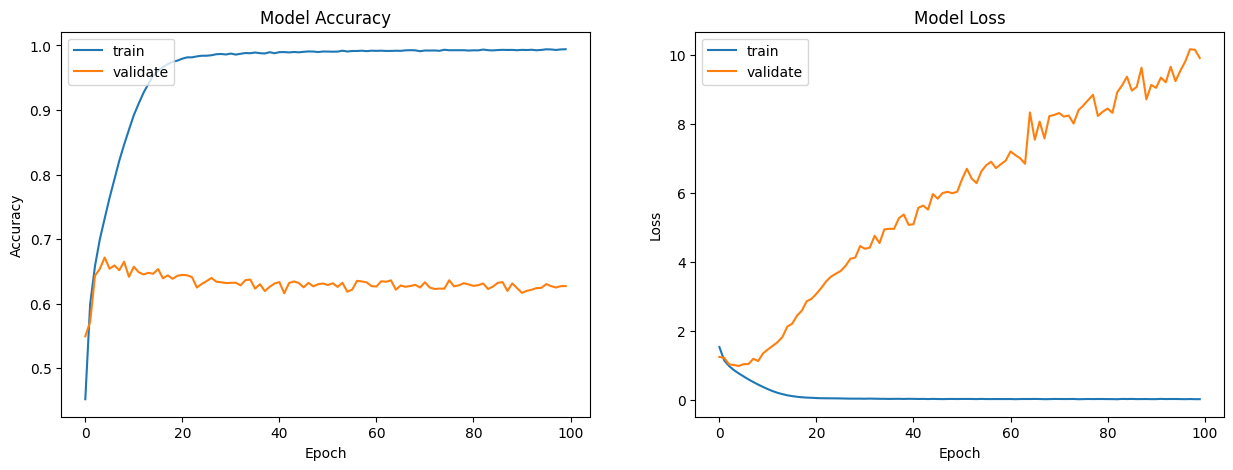

In [22]:
plot_history(history_a, 'model_a')

In [38]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_a)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_a)
lowest_loss = history_a.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_a', N_EPOCHS, BATCH_SIZE, 1, 32, model_a.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 8ms/step - loss: 7.3295 - accuracy: 0.6259
Test loss: 7.329469680786133
Test accu: 0.6259000301361084
Min loss at epoch: 7
Max accu at epoch: 11


(7, 11)

In [36]:
# model 'b' with two convolutional block depth
model_b = conv2d_model(blocks=2)
model_b.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_69 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_71 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                

In [31]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_b = model_b.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 8s 19ms/step - loss: 1.8074 - accuracy: 0.3493 - val_loss: 2.2466 - val_accuracy: 0.3220
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3956 - accuracy: 0.5014 - val_loss: 1.3134 - val_accuracy: 0.5292
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 1.1766 - accuracy: 0.5851 - val_loss: 1.0745 - val_accuracy: 0.6273
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 1.0205 - accuracy: 0.6416 - val_loss: 0.9845 - val_accuracy: 0.6587
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 0.9023 - accuracy: 0.6861 - val_loss: 0.9424 - val_accuracy: 0.6709
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 0.8005 - accuracy: 0.7211 - val_loss: 0.9197 - val_accuracy: 0.6823
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 0.7178 - accuracy: 0.7510 - val_loss: 0.9813 - val_accuracy:

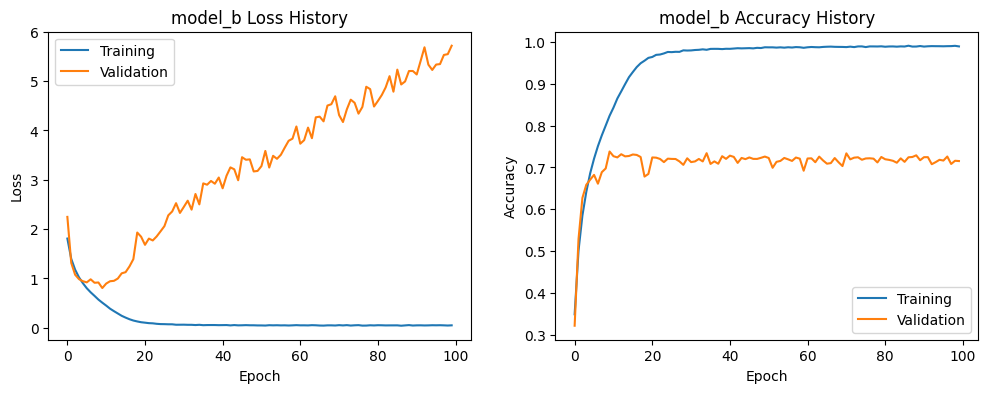

In [32]:
plot_history(history_b, 'model_b')

In [33]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_b)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_b)
lowest_loss = history_b.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_b', N_EPOCHS, BATCH_SIZE, 2, 32, model_b.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 8ms/step - loss: 5.9244 - accuracy: 0.7152
Test loss: 5.9244489669799805
Test accu: 0.7152000069618225
Min loss at epoch: 9
Max accu at epoch: 9


(9, 9)

In [34]:
# model 'c' with doubled layer sizes
model_c = conv2d_model(blocks=2, layer_size=2)
model_c.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                  

In [35]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_c = model_c.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 10s 25ms/step - loss: 1.7619 - accuracy: 0.3662 - val_loss: 1.7108 - val_accuracy: 0.4163
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 1.2627 - accuracy: 0.5554 - val_loss: 1.1086 - val_accuracy: 0.6141
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 1.0080 - accuracy: 0.6496 - val_loss: 0.9848 - val_accuracy: 0.6519
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 0.8260 - accuracy: 0.7135 - val_loss: 0.8149 - val_accuracy: 0.7215
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6802 - accuracy: 0.7635 - val_loss: 1.0045 - val_accuracy: 0.6804
Epoch 6/100
313/313 [==============================] - 7s 22ms/step - loss: 0.5570 - accuracy: 0.8082 - val_loss: 0.7574 - val_accuracy: 0.7539
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4392 - accuracy: 0.8473 - val_loss: 0.9066 - val_accuracy

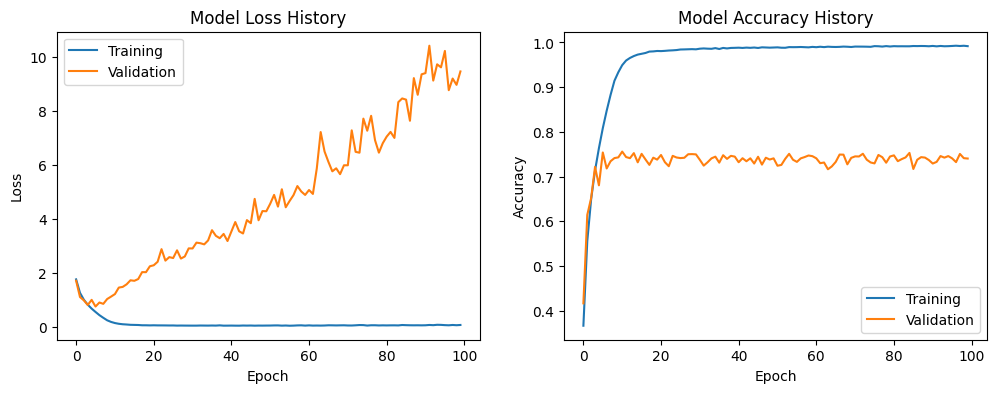

In [36]:
plot_history(history_c, 'model_c')

In [37]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_c)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_c)
lowest_loss = history_c.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_c', N_EPOCHS, BATCH_SIZE, 2, 64, model_c.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 8ms/step - loss: 9.4563 - accuracy: 0.7357
Test loss: 9.456305503845215
Test accu: 0.7357000112533569
Min loss at epoch: 5
Max accu at epoch: 10


(5, 10)

## Adding extra padding to the kernel

- bit of a hack to reduce the decreasing rate of image dimension over network depth
- native image sample resolution is small
- without padding of 0's will hit negative dimensions in block 3


In [30]:
# 3 block model test
model_d = conv2d_model(blocks=3, padding='same')
model_d.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

In [43]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_d = model_d.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 9s 24ms/step - loss: 1.9186 - accuracy: 0.3092 - val_loss: 1.6476 - val_accuracy: 0.4113
Epoch 2/100
313/313 [==============================] - 8s 24ms/step - loss: 1.3751 - accuracy: 0.5075 - val_loss: 1.1555 - val_accuracy: 0.5862
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 1.0866 - accuracy: 0.6149 - val_loss: 1.0481 - val_accuracy: 0.6259
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.8804 - accuracy: 0.6910 - val_loss: 0.9333 - val_accuracy: 0.6789
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.7345 - accuracy: 0.7424 - val_loss: 1.1891 - val_accuracy: 0.5920
Epoch 6/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6032 - accuracy: 0.7903 - val_loss: 0.8255 - val_accuracy: 0.7253
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 0.4926 - accuracy: 0.8266 - val_loss: 0.7846 - val_accuracy:

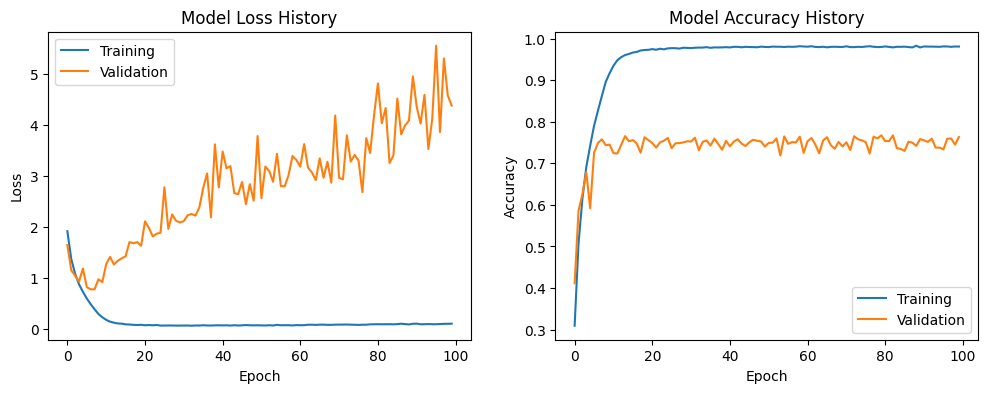

In [44]:
plot_history(history_d, 'model_d')

In [45]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_d)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_d)
lowest_loss = history_d.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_d', N_EPOCHS, BATCH_SIZE, 3, 32, model_d.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 9ms/step - loss: 4.6757 - accuracy: 0.7457
Test loss: 4.6756510734558105
Test accu: 0.7457000613212585
Min loss at epoch: 7
Max accu at epoch: 79


(7, 79)

In [33]:
# model 'e' with doubled layer sizes
model_e = conv2d_model(blocks=3, layer_size=2, padding='same')

model_e.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                

In [48]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_e = model_e.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 13s 38ms/step - loss: 2.1180 - accuracy: 0.2470 - val_loss: 1.6399 - val_accuracy: 0.3969
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 1.4475 - accuracy: 0.4799 - val_loss: 1.2376 - val_accuracy: 0.5685
Epoch 3/100
313/313 [==============================] - 11s 36ms/step - loss: 1.0892 - accuracy: 0.6166 - val_loss: 1.0546 - val_accuracy: 0.6237
Epoch 4/100
313/313 [==============================] - 11s 36ms/step - loss: 0.8423 - accuracy: 0.7063 - val_loss: 0.8875 - val_accuracy: 0.7005
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6553 - accuracy: 0.7713 - val_loss: 0.7769 - val_accuracy: 0.7434
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5095 - accuracy: 0.8229 - val_loss: 0.8502 - val_accuracy: 0.7264
Epoch 7/100
313/313 [==============================] - 11s 36ms/step - loss: 0.3820 - accuracy: 0.8673 - val_loss: 0.7434 - val_ac

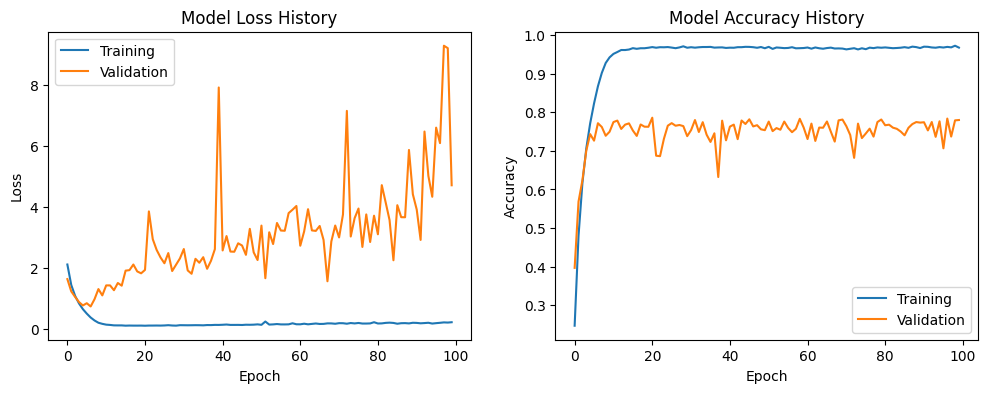

In [49]:
plot_history(history_e, 'model_e')

In [50]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_e)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_e)
lowest_loss = history_e.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_e', N_EPOCHS, BATCH_SIZE, 3, 64, model_e.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 8ms/step - loss: 4.6642 - accuracy: 0.7773
Test loss: 4.6641974449157715
Test accu: 0.7773000597953796
Min loss at epoch: 6
Max accu at epoch: 20


(6, 20)

## Comparison of Different Layer Sizes

- curves get quite noisy, will use a moving average over last 10 points to smooth line
-


In [14]:
# plot histories of models tested so far
histories = [history_a, history_b, history_c, history_d, history_e]
params = ['blocks=1', 'blocks=2', 'blocks=2, lsize=2',
          'blocks=3', 'blocks=3, lsize=2']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Layer Size',
                        lim=17,
                        dotted=[3, 5])

NameError: name 'history_a' is not defined

# 7 Regularizing and Tuning Hyperparameters

    Dropout layers
    Different Architectures
    L1 and L2 Regularization
     Demonstrate graphically regularization and taming overfitting


- use personal intuition and informed guesswork instead of a grid/random search technique to find optimal hyperparameters
- and observing loss curves to estimate the direction to go towards


In [14]:
"""
three block model following vgg16
"""
def conv2d_with_reg(blocks=1, dropout=None, grad_dropout=False,
                    optimizer='rmsprop', regularizer=None, layer_size=1):
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizer,
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(layers.Dropout(dropout))

    # block 2
    if blocks > 1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout:
            if grad_dropout:
                model.add(layers.Dropout(dropout * 1.2))
            else:
                model.add(layers.Dropout(dropout))

    # block 3
    if blocks > 2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout:
            if grad_dropout:
                model.add(layers.Dropout(dropout * 1.6))
            else:
                model.add(layers.Dropout(dropout))

    # head
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2, blocks-1) * layer_size,
                           activation='relu',
                           kernel_regularizer=regularizer))
    if dropout:
        if grad_dropout:
            model.add(layers.Dropout(dropout * 2))
        else:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameter functions
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## Dropout Testing


In [54]:
# model with dropout=0.25
model_i = conv2d_with_reg(blocks=3, dropout=0.25)

model_i.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_115 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_116 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_117 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [55]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_i = model_i.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/100
313/313 [==============================] - 13s 36ms/step - loss: 1.8932 - accuracy: 0.3103 - val_loss: 1.6622 - val_accuracy: 0.4075
Epoch 2/100
313/313 [==============================] - 11s 35ms/step - loss: 1.4695 - accuracy: 0.4657 - val_loss: 1.2857 - val_accuracy: 0.5312
Epoch 3/100
313/313 [==============================] - 11s 36ms/step - loss: 1.2487 - accuracy: 0.5553 - val_loss: 1.0965 - val_accuracy: 0.6126
Epoch 4/100
313/313 [==============================] - 10s 33ms/step - loss: 1.0861 - accuracy: 0.6167 - val_loss: 0.9688 - val_accuracy: 0.6596
Epoch 5/100
313/313 [==============================] - 12s 38ms/step - loss: 0.9679 - accuracy: 0.6597 - val_loss: 0.8919 - val_accuracy: 0.6889
Epoch 6/100
313/313 [==============================] - 11s 34ms/step - loss: 0.8669 - accuracy: 0.6983 - val_loss: 0.8831 - val_accuracy: 0.6886
Epoch 7/100
313/313 [==============================] - 11s 34ms/step - loss: 0.7892 - accuracy: 0.7238 - val_loss: 0.7793 - val_ac

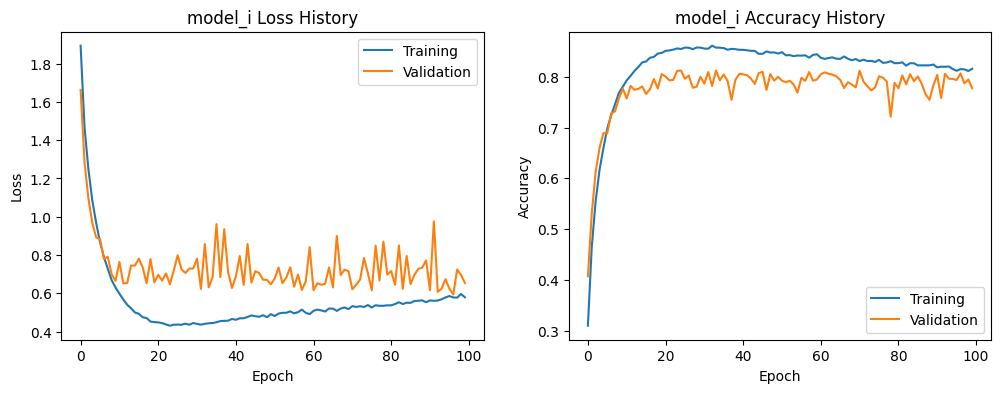

In [56]:
plot_history(history_i, 'model_i')

In [57]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_i)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_i)
lowest_loss = history_i.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_i', N_EPOCHS, BATCH_SIZE, 3, 32, model_i.count_params(),
                      0.25, 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 9ms/step - loss: 0.6738 - accuracy: 0.7738
Test loss: 0.6738208532333374
Test accu: 0.7738000154495239
Min loss at epoch: 96
Max accu at epoch: 33


(96, 33)

In [58]:
# model with dropout=0.5
model_ii = conv2d_with_reg(blocks=3, dropout=0.5)

model_ii.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_121 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_122 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_123 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [59]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_ii = model_ii.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 13s 35ms/step - loss: 2.0432 - accuracy: 0.2460 - val_loss: 1.7098 - val_accuracy: 0.3731
Epoch 2/100
313/313 [==============================] - 10s 33ms/step - loss: 1.6358 - accuracy: 0.4030 - val_loss: 1.4288 - val_accuracy: 0.4718
Epoch 3/100
313/313 [==============================] - 10s 33ms/step - loss: 1.4576 - accuracy: 0.4747 - val_loss: 1.3071 - val_accuracy: 0.5305
Epoch 4/100
313/313 [==============================] - 10s 33ms/step - loss: 1.3274 - accuracy: 0.5240 - val_loss: 1.2608 - val_accuracy: 0.5594
Epoch 5/100
313/313 [==============================] - 10s 33ms/step - loss: 1.2224 - accuracy: 0.5638 - val_loss: 1.0416 - val_accuracy: 0.6245
Epoch 6/100
313/313 [==============================] - 10s 32ms/step - loss: 1.1507 - accuracy: 0.5909 - val_loss: 0.9884 - val_accuracy: 0.6412
Epoch 7/100
313/313 [==============================] - 10s 33ms/step - loss: 1.1013 - accuracy: 0.6111 - val_loss: 0.9258 - val_ac

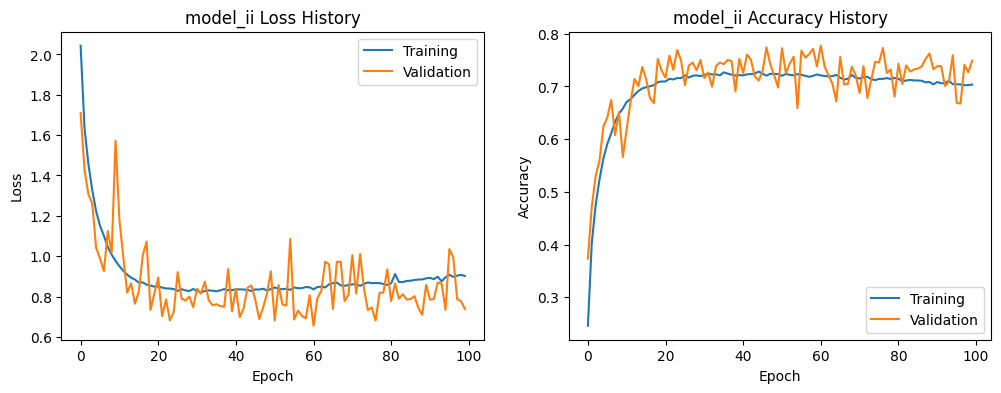

In [60]:
plot_history(history_ii, 'model_ii')

In [61]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_ii)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_ii)
lowest_loss = history_ii.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_ii', N_EPOCHS, BATCH_SIZE, 3, 32, model_ii.count_params(),
                      0.5, 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 4s 12ms/step - loss: 0.7445 - accuracy: 0.7460
Test loss: 0.7445365786552429
Test accu: 0.7460000514984131
Min loss at epoch: 60
Max accu at epoch: 60


(60, 60)

In [62]:
# model with increasing dropout between sequential blocks from [0.25, 0.5]
model_iii = conv2d_with_reg(blocks=3, dropout=0.25, grad_dropout=True)

model_iii.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_126 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_127 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_128 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_129 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [63]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_iii = model_iii.fit(x_partial, y_partial,
                            validation_data=(x_val, y_val),
                            epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                            verbose=1)

Epoch 1/100
313/313 [==============================] - 14s 39ms/step - loss: 2.0197 - accuracy: 0.2494 - val_loss: 1.7289 - val_accuracy: 0.3399
Epoch 2/100
313/313 [==============================] - 13s 40ms/step - loss: 1.5909 - accuracy: 0.4195 - val_loss: 1.4244 - val_accuracy: 0.4814
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 1.3693 - accuracy: 0.5091 - val_loss: 1.2408 - val_accuracy: 0.5635
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 1.2075 - accuracy: 0.5699 - val_loss: 1.2416 - val_accuracy: 0.5518
Epoch 5/100
313/313 [==============================] - 14s 44ms/step - loss: 1.0909 - accuracy: 0.6140 - val_loss: 1.0246 - val_accuracy: 0.6275
Epoch 6/100
313/313 [==============================] - 14s 46ms/step - loss: 0.9972 - accuracy: 0.6508 - val_loss: 0.8977 - val_accuracy: 0.6887
Epoch 7/100
313/313 [==============================] - 12s 38ms/step - loss: 0.9373 - accuracy: 0.6705 - val_loss: 0.8340 - val_ac

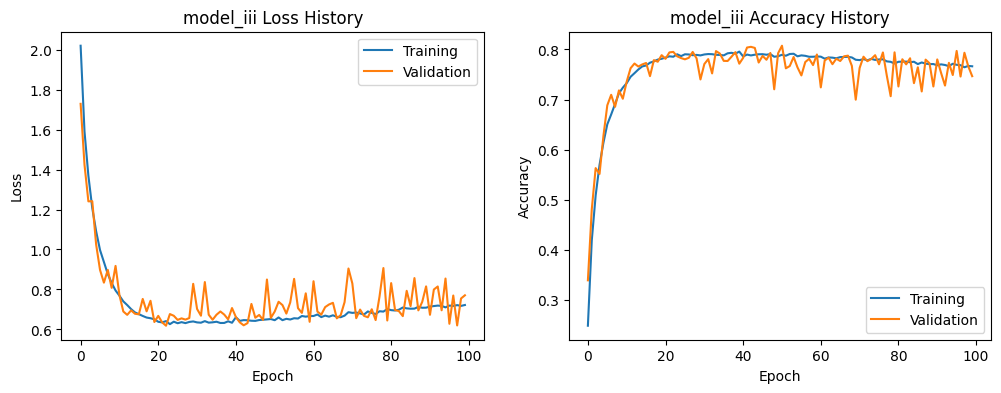

In [64]:
plot_history(history_iii, 'model_iii')

In [65]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_iii)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_iii)
lowest_loss = history_iii.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_iii', N_EPOCHS, BATCH_SIZE, 3, 32, model_iii.count_params(),
                      [0.25, 0.5], 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 5s 14ms/step - loss: 0.7634 - accuracy: 0.7512
Test loss: 0.7633751034736633
Test accu: 0.7512000203132629
Min loss at epoch: 22
Max accu at epoch: 50


(22, 50)

### Comparison of Dropout Testing


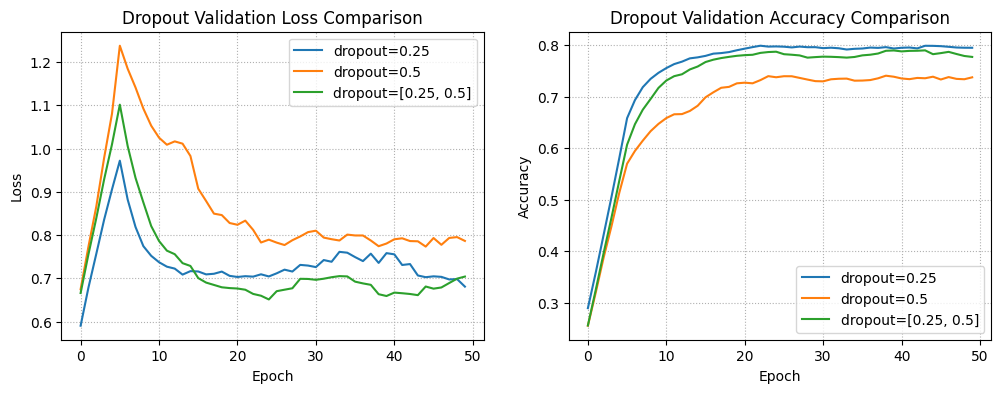

In [174]:
# plot histories of models with dropout
histories = [history_e, history_i, history_ii, history_iii]
params = ['no dropout', 'dropout=0.25', 'dropout=0.5', 'dropout=[0.25, 0.5]']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Dropout',
                        lim=50)

## Optimizer Testing


In [79]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with adjusted RMSprop optimizer
model_or = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer=OPT)

model_or.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_160 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_161 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_162 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_163 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [80]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_or = model_or.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 57s 36ms/step - loss: 2.1122 - accuracy: 0.2039 - val_loss: 1.9194 - val_accuracy: 0.3221
Epoch 2/100
313/313 [==============================] - 10s 33ms/step - loss: 1.8740 - accuracy: 0.3120 - val_loss: 1.9338 - val_accuracy: 0.3024
Epoch 3/100
313/313 [==============================] - 11s 34ms/step - loss: 1.7452 - accuracy: 0.3631 - val_loss: 1.6205 - val_accuracy: 0.4103
Epoch 4/100
313/313 [==============================] - 10s 33ms/step - loss: 1.6581 - accuracy: 0.3929 - val_loss: 1.5345 - val_accuracy: 0.4369
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 1.5742 - accuracy: 0.4238 - val_loss: 1.5137 - val_accuracy: 0.4447
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 1.5109 - accuracy: 0.4507 - val_loss: 1.4224 - val_accuracy: 0.4829
Epoch 7/100
313/313 [==============================] - 26s 82ms/step - loss: 1.4713 - accuracy: 0.4686 - val_loss: 1.4408 - val_ac

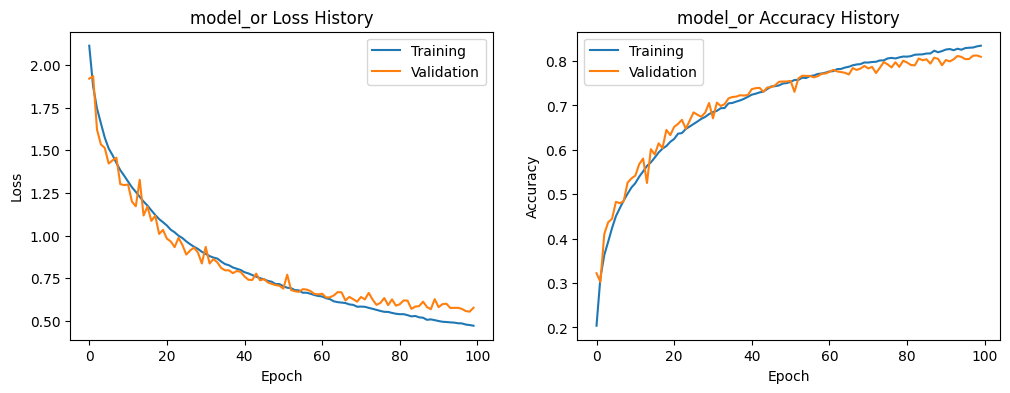

In [81]:
plot_history(history_or, 'model_or')

In [136]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_or)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_or)
lowest_loss = history_or.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_or', N_EPOCHS, BATCH_SIZE, 3, 32, model_or.count_params(),
                      [0.25, 0.5], 'rmsprop*', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 11ms/step - loss: 0.5865 - accuracy: 0.8106
Test loss: 0.5865114331245422
Test accu: 0.8106000423431396
Min loss at epoch: 98
Max accu at epoch: 98


(98, 98)

In [83]:
# model with optimizer='adam'
model_oa = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer='adam')

model_oa.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_166 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_167 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_63 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_168 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_169 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [84]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_oa = model_oa.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 12s 33ms/step - loss: 1.8198 - accuracy: 0.3204 - val_loss: 1.4559 - val_accuracy: 0.4652
Epoch 2/100
313/313 [==============================] - 11s 35ms/step - loss: 1.3745 - accuracy: 0.4999 - val_loss: 1.2058 - val_accuracy: 0.5617
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 1.1694 - accuracy: 0.5797 - val_loss: 1.0354 - val_accuracy: 0.6341
Epoch 4/100
313/313 [==============================] - 11s 34ms/step - loss: 1.0442 - accuracy: 0.6281 - val_loss: 0.9518 - val_accuracy: 0.6526
Epoch 5/100
313/313 [==============================] - 10s 33ms/step - loss: 0.9553 - accuracy: 0.6623 - val_loss: 0.8318 - val_accuracy: 0.7066
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.8845 - accuracy: 0.6849 - val_loss: 0.7877 - val_accuracy: 0.7179
Epoch 7/100
313/313 [==============================] - 10s 32ms/step - loss: 0.8328 - accuracy: 0.7058 - val_loss: 0.7458 - val_ac

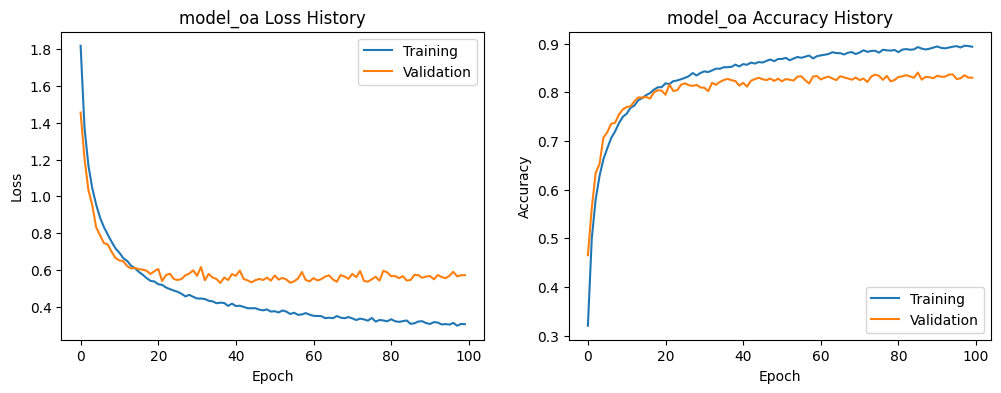

In [85]:
plot_history(history_oa, 'model_oa')

In [86]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_oa)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_oa)
lowest_loss = history_oa.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_oa', N_EPOCHS, BATCH_SIZE, 3, 32, model_oa.count_params(),
                      [0.25, 0.5], 'adam', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 4s 11ms/step - loss: 0.6045 - accuracy: 0.8244
Test loss: 0.6045360565185547
Test accu: 0.8244000673294067
Min loss at epoch: 36
Max accu at epoch: 85


(36, 85)

In [101]:
# model with optimizer='adagrad'
model_og = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer='adagrad')

model_og.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_196 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_197 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_83 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_198 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_199 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [102]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_og = model_og.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 18s 54ms/step - loss: 2.3045 - accuracy: 0.0981 - val_loss: 2.3018 - val_accuracy: 0.1247
Epoch 2/100
313/313 [==============================] - 15s 47ms/step - loss: 2.3019 - accuracy: 0.1033 - val_loss: 2.3008 - val_accuracy: 0.1327
Epoch 3/100
313/313 [==============================] - 13s 41ms/step - loss: 2.3005 - accuracy: 0.1090 - val_loss: 2.2997 - val_accuracy: 0.1381
Epoch 4/100
313/313 [==============================] - 11s 37ms/step - loss: 2.2993 - accuracy: 0.1084 - val_loss: 2.2983 - val_accuracy: 0.1447
Epoch 5/100
313/313 [==============================] - 12s 38ms/step - loss: 2.2969 - accuracy: 0.1132 - val_loss: 2.2958 - val_accuracy: 0.1447
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 2.2930 - accuracy: 0.1151 - val_loss: 2.2910 - val_accuracy: 0.1449
Epoch 7/100
313/313 [==============================] - 12s 37ms/step - loss: 2.2842 - accuracy: 0.1206 - val_loss: 2.2805 - val_ac

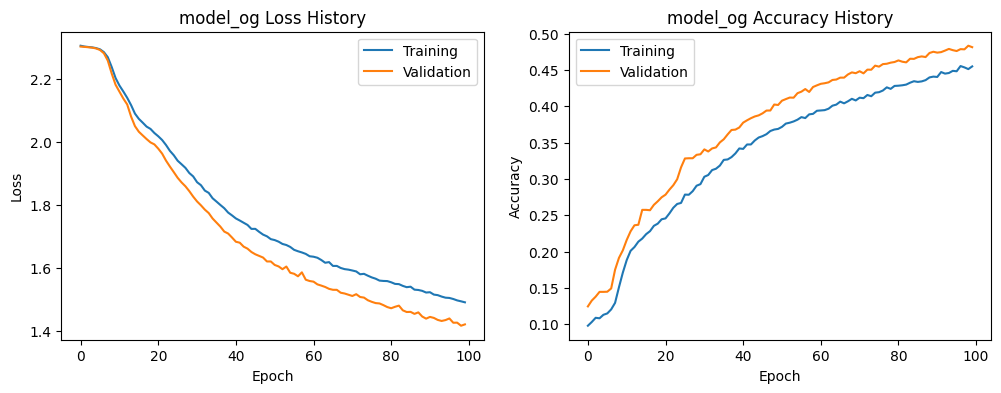

In [103]:
plot_history(history_og, 'model_og')

In [104]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_og)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_og)
lowest_loss = history_og.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_og', N_EPOCHS, BATCH_SIZE, 3, 32, model_og.count_params(),
                      [0.25, 0.5], 'adagrad', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 4s 11ms/step - loss: 1.4089 - accuracy: 0.4838
Test loss: 1.408939003944397
Test accu: 0.4838000237941742
Min loss at epoch: 98
Max accu at epoch: 98


(98, 98)

### Comparison of Optimizers


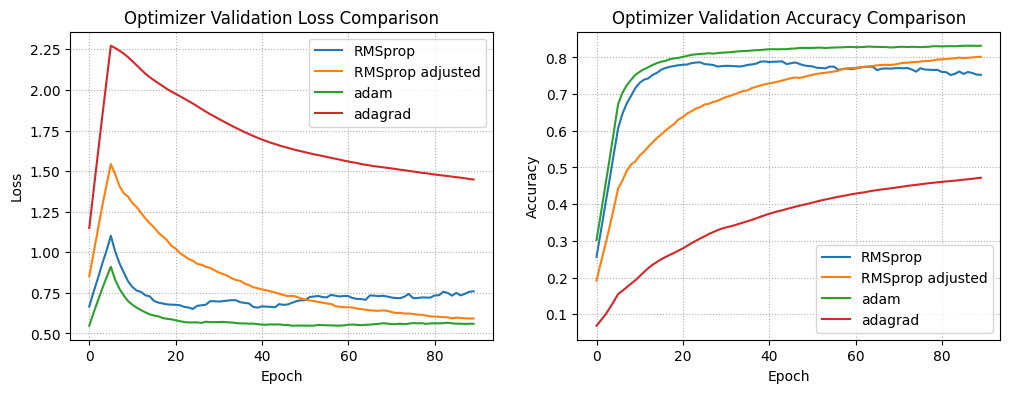

In [169]:
# plot histories of models with dropout
histories = [history_iii, history_or, history_oa, history_og]
params = ['RMSprop', 'RMSprop adjusted', 'adam', 'adagrad']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Optimizer',
                        lim=90)

## L1/L2 Regularizer Testing


In [120]:
REG = regularizers.l1(1e-4)
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with l1=0.0001 regularization
model_l1 = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer=OPT, regularizer=REG)

model_l1.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_244 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_245 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_115 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_246 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_247 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [121]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_l1 = model_l1.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 12s 35ms/step - loss: 2.3511 - accuracy: 0.2710 - val_loss: 1.8622 - val_accuracy: 0.3777
Epoch 2/100
313/313 [==============================] - 10s 31ms/step - loss: 1.8304 - accuracy: 0.3885 - val_loss: 1.6883 - val_accuracy: 0.4510
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 1.7376 - accuracy: 0.4282 - val_loss: 1.6222 - val_accuracy: 0.4707
Epoch 4/100
313/313 [==============================] - 10s 31ms/step - loss: 1.6864 - accuracy: 0.4493 - val_loss: 1.5843 - val_accuracy: 0.4929
Epoch 5/100
313/313 [==============================] - 10s 31ms/step - loss: 1.6479 - accuracy: 0.4647 - val_loss: 1.5187 - val_accuracy: 0.5226
Epoch 6/100
313/313 [==============================] - 10s 31ms/step - loss: 1.6094 - accuracy: 0.4852 - val_loss: 1.4676 - val_accuracy: 0.5395
Epoch 7/100
313/313 [==============================] - 10s 31ms/step - loss: 1.5671 - accuracy: 0.5020 - val_loss: 1.4419 - val_acc

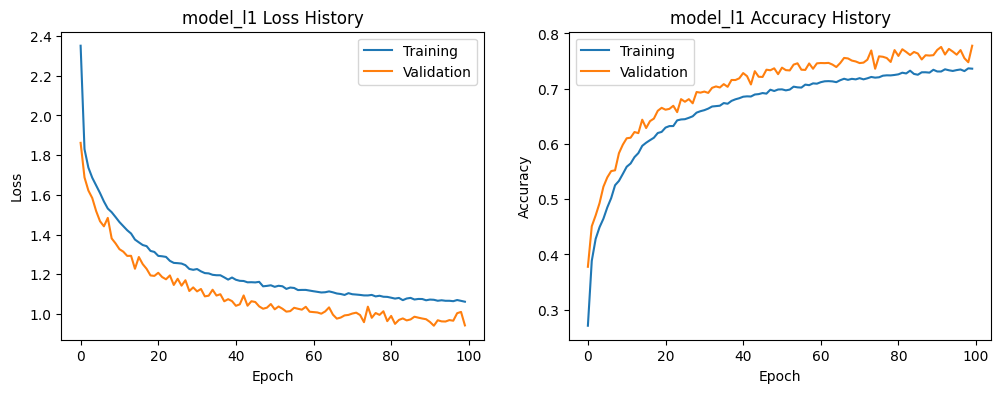

In [122]:
plot_history(history_l1, 'model_l1')

In [123]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_l1)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_l1)
lowest_loss = history_l1.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_l1', N_EPOCHS, BATCH_SIZE, 3, 32, model_l1.count_params(),
                      [0.25, 0.5], 'rmsprop*', 'l1=1e-4', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 4s 13ms/step - loss: 0.9521 - accuracy: 0.7761
Test loss: 0.9521194100379944
Test accu: 0.7761000394821167
Min loss at epoch: 91
Max accu at epoch: 99


(91, 99)

In [124]:
REG = regularizers.l2(1e-4)
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with l2=0.0001 regularization
model_l2 = conv2d_with_reg(blocks=3, dropout=0.25,
                           grad_dropout=True, optimizer=OPT, regularizer=REG)

model_l2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_250 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_251 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_119 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_252 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_253 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [125]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_l2 = model_l2.fit(x_partial, y_partial,
                          validation_data=(x_val, y_val),
                          epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                          verbose=1)

Epoch 1/100
313/313 [==============================] - 35s 107ms/step - loss: 1.8862 - accuracy: 0.3164 - val_loss: 1.4736 - val_accuracy: 0.4744
Epoch 2/100
313/313 [==============================] - 36s 115ms/step - loss: 1.4406 - accuracy: 0.4945 - val_loss: 1.2439 - val_accuracy: 0.5745
Epoch 3/100
313/313 [==============================] - 37s 117ms/step - loss: 1.2566 - accuracy: 0.5721 - val_loss: 1.0796 - val_accuracy: 0.6374
Epoch 4/100
313/313 [==============================] - 35s 113ms/step - loss: 1.1443 - accuracy: 0.6167 - val_loss: 1.1165 - val_accuracy: 0.6281
Epoch 5/100
313/313 [==============================] - 33s 105ms/step - loss: 1.0788 - accuracy: 0.6483 - val_loss: 0.9608 - val_accuracy: 0.6880
Epoch 6/100
313/313 [==============================] - 30s 97ms/step - loss: 1.0086 - accuracy: 0.6765 - val_loss: 0.9152 - val_accuracy: 0.7057
Epoch 7/100
313/313 [==============================] - 33s 105ms/step - loss: 0.9626 - accuracy: 0.6978 - val_loss: 0.8673 - 

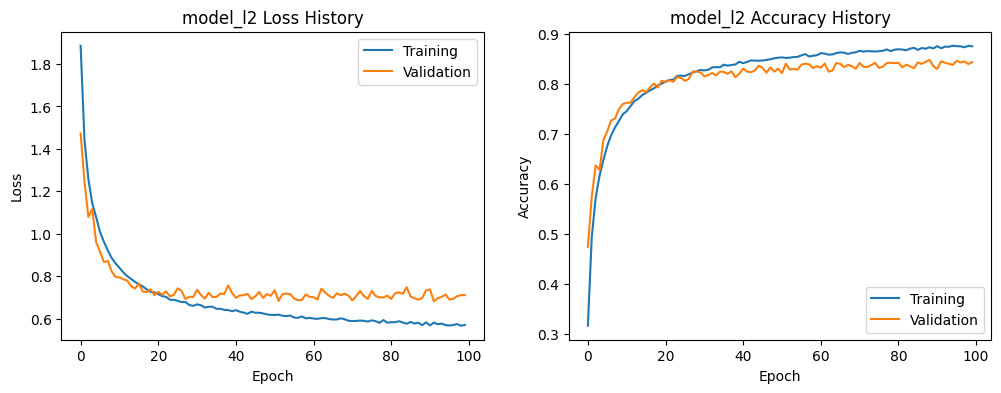

In [126]:
plot_history(history_l2, 'model_l2')

In [127]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_l2)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_l2)
lowest_loss = history_l2.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_l2', N_EPOCHS, BATCH_SIZE, 3, 32, model_l2.count_params(),
                      [0.25, 0.5], 'rmsprop*', 'l2=1e-4', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 4s 13ms/step - loss: 0.7236 - accuracy: 0.8408
Test loss: 0.7235672473907471
Test accu: 0.8408000469207764
Min loss at epoch: 91
Max accu at epoch: 88


(91, 88)

In [140]:
REG = regularizers.l2(1e-3)
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# model with l2=0.001 regularization
model_l2a = conv2d_with_reg(blocks=3, dropout=0.25, grad_dropout=True,
                            optimizer=OPT, regularizer=REG)

model_l2a.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_262 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_263 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_130 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_127 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_264 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_265 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [141]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_l2a = model_l2a.fit(x_partial, y_partial,
                            validation_data=(x_val, y_val),
                            epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                            verbose=1)

Epoch 1/100
313/313 [==============================] - 23s 68ms/step - loss: 2.0732 - accuracy: 0.2864 - val_loss: 1.6709 - val_accuracy: 0.4153
Epoch 2/100
313/313 [==============================] - 25s 81ms/step - loss: 1.6675 - accuracy: 0.4279 - val_loss: 1.4876 - val_accuracy: 0.5052
Epoch 3/100
313/313 [==============================] - 24s 77ms/step - loss: 1.5424 - accuracy: 0.4906 - val_loss: 1.4114 - val_accuracy: 0.5556
Epoch 4/100
313/313 [==============================] - 21s 67ms/step - loss: 1.4493 - accuracy: 0.5363 - val_loss: 1.3089 - val_accuracy: 0.5862
Epoch 5/100
313/313 [==============================] - 17s 55ms/step - loss: 1.3764 - accuracy: 0.5663 - val_loss: 1.3065 - val_accuracy: 0.5965
Epoch 6/100
313/313 [==============================] - 17s 53ms/step - loss: 1.3313 - accuracy: 0.5861 - val_loss: 1.2197 - val_accuracy: 0.6326
Epoch 7/100
313/313 [==============================] - 19s 59ms/step - loss: 1.2988 - accuracy: 0.6069 - val_loss: 1.1934 - val_ac

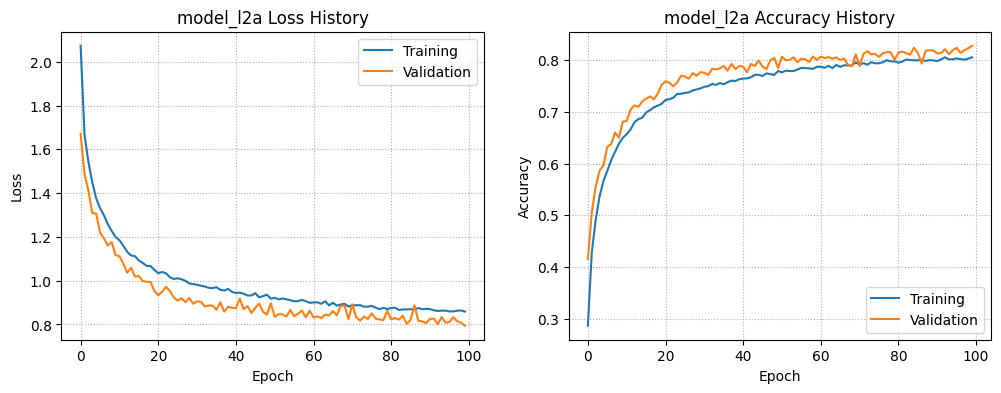

In [166]:
plot_history(history_l2a, 'model_l2a')

In [143]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_l2a)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_l2a)
lowest_loss = history_l2a.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_l2a', N_EPOCHS, BATCH_SIZE, 3, 32, model_l2a.count_params(),
                      [0.25, 0.5], 'rmsprop*', 'l2=1e-3', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 9ms/step - loss: 0.8015 - accuracy: 0.8246
Test loss: 0.8014827370643616
Test accu: 0.8246000409126282
Min loss at epoch: 99
Max accu at epoch: 99


(99, 99)

### Comparison of Regularizers


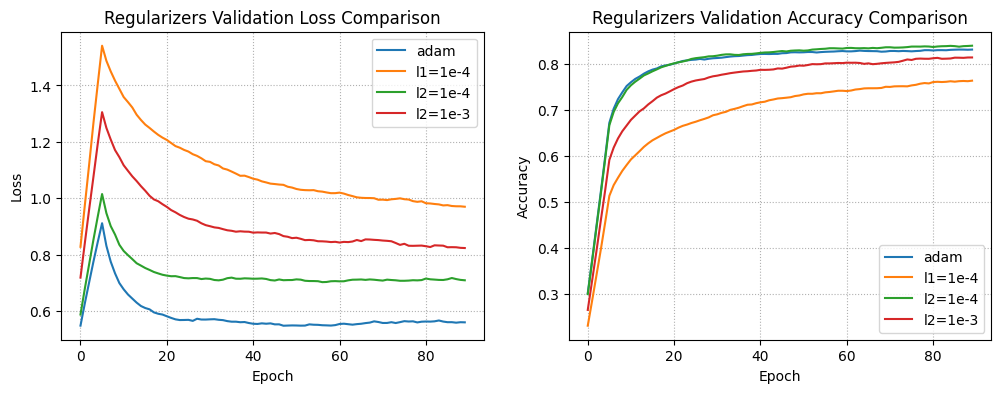

In [165]:
# plot histories of models with dropout
histories = [history_oa, history_l1, history_l2, history_l2a]
params = ['rmsprop adjusted', 'l1=1e-4', 'l2=1e-4', 'l2=1e-3']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Regularizers',
                        lim=100)

# 8 Testing

Retrain best model on all training data Evaluate ONCE on test set


- `adam` and the adjusted `rmsprop` have similar loss and accuracy convergence
- the trade off being `adam` performs best without further regularization
- I will use rmsprop with the prospect it could potentially have lower loss with longer training


In [25]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# adjusted rmsprop model without regularizers
# change to model_s
model_s = conv2d_with_reg(blocks=3, dropout=0.25,
                          grad_dropout=True, optimizer=OPT)

model_s.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [26]:
N_EPOCHS = 200
BATCH_SIZE = 128


history_s = model_s.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/200
313/313 [==============================] - 13s 36ms/step - loss: 2.1477 - accuracy: 0.1962 - val_loss: 2.0070 - val_accuracy: 0.2769
Epoch 2/200
313/313 [==============================] - 11s 36ms/step - loss: 1.9199 - accuracy: 0.3002 - val_loss: 1.7797 - val_accuracy: 0.3630
Epoch 3/200
313/313 [==============================] - 11s 36ms/step - loss: 1.7761 - accuracy: 0.3536 - val_loss: 1.6560 - val_accuracy: 0.4043
Epoch 4/200
313/313 [==============================] - 11s 35ms/step - loss: 1.6815 - accuracy: 0.3896 - val_loss: 1.5761 - val_accuracy: 0.4339
Epoch 5/200
313/313 [==============================] - 11s 35ms/step - loss: 1.6046 - accuracy: 0.4154 - val_loss: 1.5092 - val_accuracy: 0.4455
Epoch 6/200
313/313 [==============================] - 11s 35ms/step - loss: 1.5437 - accuracy: 0.4404 - val_loss: 1.4621 - val_accuracy: 0.4745
Epoch 7/200
313/313 [==============================] - 11s 35ms/step - loss: 1.4903 - accuracy: 0.4629 - val_loss: 1.4454 - val_ac

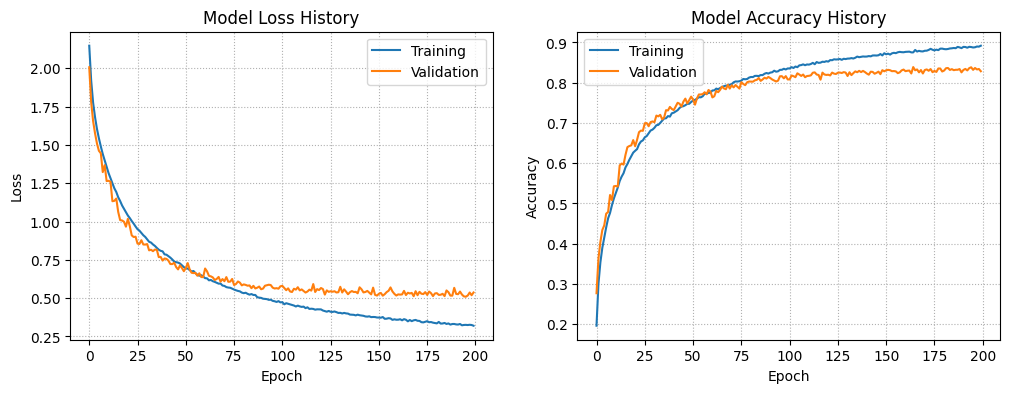

In [27]:
plot_history(history_s, 'model_s')

In [54]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(model_s)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(history_s)
lowest_loss = history_s.history['val_loss'][loss_epoch]

# store results
model_summary.append(['model_s', N_EPOCHS, BATCH_SIZE, 3, 32, model_s.count_params(),
                      [0.25, 0.5], 'rmsprop*', '-', loss_epoch, lowest_loss, loss_test, accu_test])

313/313 [==============================] - 3s 11ms/step - loss: 0.5566 - accuracy: 0.8198
Test loss: 0.556562602519989
Test accu: 0.8198000192642212
Min loss at epoch: 195
Max accu at epoch: 164


## Final Testing Set Training


In [24]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

model_t = conv2d_with_reg(blocks=3, dropout=0.25,
                          grad_dropout=True, optimizer=OPT)

model_t.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [18]:
N_EPOCHS = loss_epoch
BATCH_SIZE = 128

X_train = prep_normalize(X_train)
y_train = prep_encoder(y_train)

history_0 = model_t.fit(X_train, y_train,
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1)

Epoch 1/148
391/391 [==============================] - 15s 34ms/step - loss: 2.1177 - accuracy: 0.2068
Epoch 2/148
391/391 [==============================] - 13s 33ms/step - loss: 1.8281 - accuracy: 0.3290
Epoch 3/148
391/391 [==============================] - 13s 33ms/step - loss: 1.7016 - accuracy: 0.3766
Epoch 4/148
391/391 [==============================] - 13s 33ms/step - loss: 1.6045 - accuracy: 0.4116
Epoch 5/148
391/391 [==============================] - 13s 33ms/step - loss: 1.5261 - accuracy: 0.4429
Epoch 6/148
391/391 [==============================] - 13s 34ms/step - loss: 1.4607 - accuracy: 0.4677
Epoch 7/148
391/391 [==============================] - 14s 36ms/step - loss: 1.4054 - accuracy: 0.4905
Epoch 8/148
391/391 [==============================] - 13s 33ms/step - loss: 1.3552 - accuracy: 0.5106
Epoch 9/148
391/391 [==============================] - 14s 35ms/step - loss: 1.3130 - accuracy: 0.5265
Epoch 10/148
391/391 [==============================] - 14s 36ms/step - l

In [40]:
loss_test, accu_test = evaluate_model(model_t)
# no val_loss to evaluate with final model

# save final model as .keras file
model_t.save('cifar10_CNN.keras')
# model = tf.keras.models.load_model('cifar10_CNN.keras')

# store results
model_summary.append(['model_t', N_EPOCHS, BATCH_SIZE, 3, 32, model_t.count_params(),
                      [0.25, 0.5], 'rmsprop*', '-', '-', '-', loss_test, accu_test])

313/313 [==============================] - 3s 11ms/step - loss: 2.3032 - accuracy: 0.1023
Test loss: 2.303212881088257
Test accu: 0.1023000031709671


In [56]:
# use final trained model_t to predict testing data
y_pred = model_t.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# get index count of false predictions
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of correct predictions: {test_samples-errors}/{test_samples}')
print(f'Prediction accuracy: {1-errors/test_samples}')

# plot incorrect preditions, true vs predicted labels
plot_multi_sample(X_test[errors_index][:10],
                  y_test[errors_index][:10].ravel(),
                  y_pred[errors_index][:10])

NameError: name 'model_t' is not defined

In [55]:
# create dataframe
column_names = ['name', 'epochs', 'batch_size', 'blocks', 'layer_size', 'parameters',
                'dropout', 'optimizer', 'regularizer', 'fit epoch', 'lowest loss', 'test loss', 'test accu']

model_df = pd.DataFrame(model_summary, columns=column_names)
# model_df.set_index('name', inplace=True)

display(model_df)

,name,epochs,batch_size,blocks,layer_size,parameters,dropout,optimizer,regularizer,fit epoch,lowest loss,test loss,test accu
0,model_0,200,128,3,32,814122,"[0.25, 0.5]",rmsprop*,-,-,-,2.303213,0.1023
1,model_1,200,128,3,32,814122,"[0.25, 0.5]",rmsprop*,-,195,0.509488,0.556563,0.8198
2,model_0,200,128,3,32,814122,"[0.25, 0.5]",rmsprop*,-,-,-,2.303213,0.1023
3,model_s,200,128,3,32,814122,"[0.25, 0.5]",rmsprop*,-,195,0.509488,0.556563,0.8198


# Ideas

- l2 regularization on every layer helps validation loss, regularizer=regularizers.l2(0.001) is too high, model is underfitting
- 0.3-0.5 dropout seems to be the sweet spot
- train final model on longer epochs
- 2 vs 3 blocks
- high dropout of 0.5 produces good accuracy and low loss, perhaps due to low quality of images (batch_size=128)


# Reflection

- process of finding optimal hyperparameters was most challenging
- hyperparameter tuning was similar to searching a stochastic space for optimal parameters
- observing small iterative changes with small training sizes is a tedious but good informed approach
- grid search of hyperparameters based on observations would have been a good approach

Not mentioned in notebook:

- batch_size increases reduced convergence rate, did not significantly increase or decrease loss and accu
- resources hhad a lot of conflicting ideas


# References

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

https://keras.io/api/layers/convolution_layers/convolution2d/

https://stackoverflow.com/questions/17888593/display-sequence-of-images-using-matplotlibmatpl

https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf alexnet

https://arxiv.org/pdf/1409.1556.pdf vgg16

#https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer

#https://github.com/hudsonmendes/uolondon-cm3015-mlnn/blob/main/final/report.ipynb


#### Misc GPU Testing


In [201]:
# native Windows tensorflow=2.10
!nvidia-smi


Wed Sep 13 21:18:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  | 00000000:01:00.0  On |                  N/A |
| 29%   56C    P0              43W / 172W |   7741MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [202]:
# Look for GPU
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))


/device:GPU:0
Found GPU at: /device:GPU:0


In [203]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
